In [24]:
%run ../../_setup.py

from netCDF4 import Dataset
from xarray import open_dataset
from shutil import copyfile
from OceanPy.netcdf import createNetCDF

import numpy as np
from scipy.interpolate import interp1d

# http://mixedlayer.ucsd.edu/ and https://github.com/garrettdreyfus/python-holteandtalley
from holteandtalley import HolteAndTalley
from OceanPy.stability import mixed_layer_depth

import matplotlib.pyplot as plt

In [25]:
# load ctd and gsw data
input_file_ctd = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file_ctd, 'r')

# load adcp data
input_file_adcp = os.path.join(datadir, 'ss9802', 'processed', 'adcp', 'ss9802_adcp_ctd.nc')
adcp = Dataset(input_file_adcp, 'r')

In [26]:
# output files
output_file_adcp_mld = os.path.join(datadir, 'ss9802', 'processed', 'adcp', 'ss9802_adcp_ctd_mld.nc')


In [27]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# transect stations
transects = {1: list(reversed(range(2, 10))), 2: list(range(10, 18)), 3: list(reversed(range(18, 27))),
             4: list(range(26, 34)), 5: list(reversed(range(36, 46))), 6: list(range(46, 57)),
             7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 76))), 9: list(range(76, 84)),
             10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 101)))}

## calculate mixed layer depth according to Holte and Talley, 2009

In [28]:
nst = ctd.dimensions['profile'].size

pressure = ctd['p'][:]
mld, pmld, imld = np.ma.masked_all(nst), np.ma.masked_all(nst), []
# pmld_sigma0 = pmld.copy()
for istat in range(nst):
    CT = ctd['CT'][istat,:]
    SA = ctd['SA'][istat,:]
    sigma0 = ctd['sigma0'][istat,:]

    mask = np.ma.masked_invalid(CT).mask | np.ma.masked_invalid(SA).mask | np.ma.masked_invalid(sigma0).mask

    h = HolteAndTalley(pressure[~mask], CT[~mask], SA[~mask], sigma0[~mask])
    mld[istat] = h.tempMLD
    pmld[istat] = round(h.tempMLD / 2) * 2
#     pmld_sigma0[istat] = round(h.densityMLD / 2) * 2

    imld.append(pressure_levels[pmld[istat]])

print('average mixed layer pressure: %s' %np.mean(pressure[imld]))


average mixed layer pressure: 94.11881188118812


## calculate mixed layer depth with OceanPy based on de Boyer Montegut et al. 2004

In [29]:
# smooth = True
# imld_old = []
# for istat in range(nst):
    
#     # read variables
#     sig0 = ctd['sigma0'][istat,]
#     pt = ctd['pt'][istat,]
#     z = ctd['z'][istat,]

#     # determine index of mixed layer depth 
#     imld_tdd, ml_dep = mixed_layer_depth(z, sig0=sig0, pt=pt, smooth=smooth)[0:2]
#     imld_old.append(imld_tdd)

# print('average mixed layer pressure: %s' %np.mean(pressure[imld_old]))

## plot mixed layer depth based on temperature for each transect

In [30]:
# keys = list(transects.keys())
# keys.insert(4, 4)

# fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharey=True, sharex=True, constrained_layout=True)
# axes[0,0].invert_yaxis()
# for ax, transect in zip(axes.flat, reversed(keys)):
#     stations = transects[transect]
    
#     ax.set_ylim([0, 300])
#     ax.invert_yaxis()
    
#     for station in stations:
#         ax.plot(ctd['CT'][station, :], pressure, 'r-')
#         ax.scatter(ctd['CT'][station, pressure_levels[pmld[station]]], 
#                       pressure[pressure_levels[pmld[station]]], facecolors='r')

# #     ax_CT.set_xlabel(ctd['CT'].long_name)



In [31]:
# fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharey=True, sharex=True, constrained_layout=True)
# axes[0,0].invert_yaxis()
# for ax, transect in zip(axes.flat, reversed(keys)):
#     stations = transects[transect]
    
#     ax.set_ylim([0, 200])
#     ax.invert_yaxis()
#     ax.set_xlim([26.4, 26.9])
    
#     for station in stations:
#         ax.plot(ctd['sigma0'][station, :], pressure, 'b-')
#         ax.scatter(ctd['sigma0'][station, pressure_levels[pmld[station]]], 
#                           pressure[pressure_levels[pmld[station]]], facecolors='b')
#         ax.scatter(ctd['sigma0'][station, pressure_levels[pmld_sigma0[station]]],
#                    pressure[pressure_levels[pmld_sigma0[station]]], facecolors='r')


## calculate direction for ADCP velocity vectors

In [32]:
# calculate orientation angle of ADCP vectors
xpos = adcp['u_ctd'][:].data < 0
ypos = adcp['v_ctd'][:].data < 0

direction = np.arctan(adcp['v_ctd'][:] / adcp['u_ctd'][:])
direction[xpos] = np.arctan(adcp['v_ctd'][:][xpos] / adcp['u_ctd'][:][xpos]) + np.pi
direction[xpos & ypos] = np.arctan(adcp['v_ctd'][:][xpos & ypos] / adcp['u_ctd'][:][xpos & ypos]) - np.pi


## interpolate adcp velocities to same pressure coordinate system as CTD

In [33]:
# construct adcp pressure levels with same interval as CTD
pctd_adcp = np.linspace(2, 352, int((352 - 2) / 2 + 1))


In [34]:
group = 'MLD'

dimensions = {
    'profile': ctd['station'].size,
    'pressure': pctd_adcp.size,
}

# nst, npf = adcp.dimensions['profile_ctd'].size, pctd_adcp.size
variables = {
    'p_ctd': ('sea_water_pressure', 'f8', ('pressure',)),
    'u_ctd': ('eastward_sea_water_velocity', 'f8', ('profile', 'pressure',)), 
    'v_ctd': ('northward_sea_water_velocity', 'f8', ('profile', 'pressure',)), 
    'dir_ctd': ('sea_water_velocity_to_direction', 'f8', ('profile', 'pressure',))
}  


In [35]:
new_variables = {}
for var in variables:
    if var == 'p_ctd':
        new_variables['/%s/%s' %(group, var)] = variables[var] + (np.ma.masked_invalid(pctd_adcp),)
    else:
        data = np.ma.masked_all((dimensions['profile'], dimensions['pressure']))
        for ist in range(dimensions['profile']):
            if var == 'dir_ctd':
                values = direction[ist, :]
            else:
                values = adcp[var][ist, :]
            mask = adcp['p_ctd'][ist, :].mask | values.mask
            try:
                f = interp1d(adcp['p_ctd'][ist, ~mask], values[~mask], bounds_error=False)
                data[ist,] = f(pctd_adcp)
            except IndexError:
                pass
        new_variables['/%s/%s' %(group, var)] = variables[var] + (data,)

## average over mixed layer variables

In [36]:
# find reference depth
ref_dep = 20
iref = pressure_levels[ref_dep]

# find index of mixed layer pressure at CTD pressure levels
ipmld = np.ma.masked_invalid([(np.abs(pctd_adcp - p)).argmin() for p in pmld])


In [37]:
variables_mld = {
    'mld': ('ocean_mixed_layer_thickness_defined_by_temperature', 'f8', ('profile',)),
    'p_mld': ('sea_water_pressure', 'f8', ('profile',)),
    'idxp_mld': ('ocean_mixed_layer_thickness_defined_by_temperature index', 'f8', ('profile',)),
    'u_mld': ('eastward_sea_water_velocity', 'f8', ('profile',)),
    'v_mld': ('northward_sea_water_velocity', 'f8', ('profile',)),
    'dir_mld': ('sea_water_velocity_to_direction', 'f8', ('profile',))
}

In [38]:
# calculate mean of velocities/ direction from reference to mixed level pressure
for var in ['u', 'v', 'dir']:
    data = []
    for ist in range(dimensions['profile']):
        try:
            data.append(np.nanmean(new_variables['/%s/%s' %(group, var + '_ctd')][3][ist, slice(iref, ipmld[ist])]))
        except ValueError:
            data.append(np.nan)
    data = np.ma.masked_invalid(data)
    new_variables['/%s/%s' %(group, var + '_mld')] = variables_mld[var + '_mld'] + (data,)


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [39]:
new_variables['/%s/%s' %(group, 'mld')] = variables_mld['mld'] + (mld,)
new_variables['/%s/%s' %(group, 'p_mld')] = variables_mld['p_mld'] + (pmld,)
new_variables['/%s/%s' %(group, 'idxp_mld')] = variables_mld['idxp_mld'] + (ipmld,)


## store in ADCP netCDF

In [40]:
if os.path.isfile(output_file_adcp_mld):
    print('Output file %s already exists.' %os.path.basename(output_file_adcp_mld))
else:
    copyfile(input_file_adcp, output_file_adcp_mld)
    print('Output file %s, copied from input file %s.'
          %(os.path.basename(output_file_adcp_mld), os.path.basename(input_file_adcp)))
    adcp_mld = createNetCDF(output_file_adcp_mld)


Output file ss9802_adcp_ctd_mld.nc, copied from input file ss9802_adcp_ctd.nc.


In [41]:
try:
    # create group
    dsgroup = adcp_mld.dataset.createGroup(group)

    # create dimensions and coordinates
    for name, size in dimensions.items():
        dsgroup.createDimension(name, size)

        if name == 'profile': 
            values = np.ma.masked_invalid(ctd['station'])
            precision = 'i4'
        elif name == 'pressure':
            values = np.ma.masked_invalid(pctd_adcp)
            precision = 'f8'

        new_variables['/%s/%s' %(group, name)] = (name, precision, name, values)

    # create variables
    adcp_mld.create_vars(new_variables)
    
    adcp_mld.close()
    
except IndexError:
    print('oops')

## open MLD variables at CTD locations and plot

In [42]:
adcp_ctd = open_dataset(output_file_adcp_mld)
adcp_mld = open_dataset(output_file_adcp_mld, group='MLD')


Text(0.5, 0, 'sea_water_conservative_temperature')

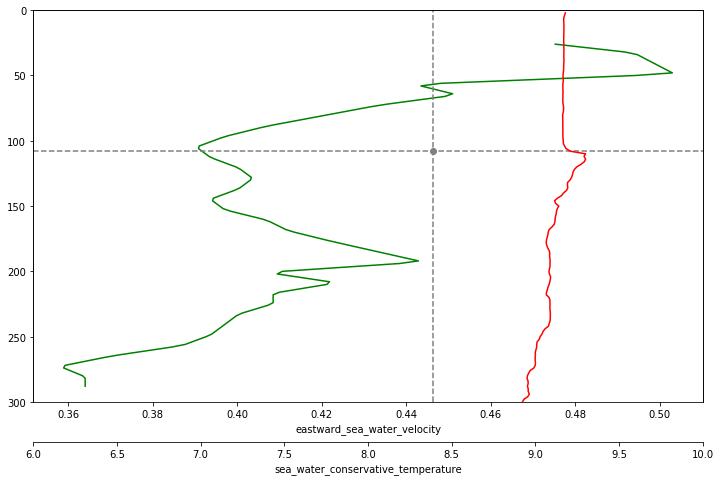

In [48]:
ist = 7

fig, ax = plt.subplots(figsize=(12,8))
ax.set_ylim([0, 300])
ax.invert_yaxis()
axCT = ax.twiny()

# Make some room at the bottom
fig.subplots_adjust(bottom=0.20)

# second axis at the bottom
axCT.set_frame_on(True)
axCT.patch.set_visible(False)
axCT.xaxis.set_ticks_position('bottom')
axCT.xaxis.set_label_position('bottom')
axCT.spines['bottom'].set_position(('outward', 40))

# plot velocity profile
ax.plot(adcp_mld['u_ctd'][ist, :], adcp_mld['p_ctd'][:], 'g')
ax.scatter(adcp_mld['u_mld'][ist], adcp_mld['p_mld'][ist], facecolors='gray')
ax.axvline(x=adcp_mld['u_mld'][ist], ymax=adcp_mld['p_mld'][ist], color='gray', linestyle='--')
ax.axhline(y=adcp_mld['p_mld'][ist], color='gray', linestyle='--')

ax.set_xlabel(adcp_mld['u_ctd'].long_name)

# plot temperature profile
axCT.plot(ctd['CT'][ist,:], ctd['p'][:], 'r', )
axCT.set_xlim([6, 10])
axCT.set_xlabel(ctd['CT'].long_name)
